<a href="https://colab.research.google.com/github/kleenman/tds_capstone/blob/jakob/Gradio_Interface_1_und_2_und_Pixelanzahl_berechnen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Laden des Modells


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *
from io import BytesIO
import requests




In [3]:
#ausführen
dataset_path = '/content/gdrive/MyDrive/Capstone/Data/munich_data'

# define mask function

def mask_function(name):
  img_name = str(name).split('/')[-1]
  mask_path = dataset_path + '/masks/' + img_name.replace('.jpg', '.npy')
  return np.load(mask_path)


In [4]:
#ausführen
# Create datablock
parks_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ['background','park'])),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=mask_function,
                 item_tfms=Resize(1000),
                 batch_tfms=aug_transforms(size=1000, max_lighting=0.3)
)

# Dataloaders with batch size 4
dls4 = parks_block.dataloaders(dataset_path, bs=4)

# Dataloaders with batch size 16
dls16 = parks_block.dataloaders(dataset_path, bs=16)

# Dataloaders with batch size 32
dls32 = parks_block.dataloaders(dataset_path, bs=32)


In [ ]:
#dls16.show_batch(figsize=(15, 15), max_n=4)

In [5]:
##

def create_and_train_learner(dl, arch=resnet34, metrics=Dice, monitor='dice', epcohs=40, fname='model', act_cls=torch.nn.modules.activation.ReLU):
  learn = unet_learner(dl, arch, metrics=metrics, act_cls=act_cls)
  lr = learn.lr_find()
  learn.fit_one_cycle(40, lr_max=lr.valley, cbs=[
      EarlyStoppingCallback(monitor=monitor,
                            min_delta=0.01,
                            patience=10,
                            comp=np.greater),
      SaveModelCallback(monitor=monitor,
                        min_delta=0.01,
                        comp=np.greater,
                        fname=fname)])
  return learn

In the next sections we will experiment with different activation functions (ELU, LeakyReLU, GELU) with the U-Net architecture and resnet34 model, while keeping all transformations and batch size constant.


The ELU activation function drastically accelerated the learning process of the model. A dice score of over 0.5 was reached as soon as epoch 19 of training, as opposed to the previous model, which used the Rectified Linear Unit activation function, and reached a comparable dice score only after unfreezing its last layers.

The ELU activation function provided slightly better performance than RELU.
Next, we will try the LeakyRELU activation function.

Finally we will unfreeze and train the last layers of the best model and export it.

In [6]:
#ausführen
path = Path('./gdrive/MyDrive/Capstone')
path.ls()

(#6) [Path('gdrive/MyDrive/Capstone/Literature'),Path('gdrive/MyDrive/Capstone/TDS2.pdf'),Path('gdrive/MyDrive/Capstone/Data'),Path('gdrive/MyDrive/Capstone/park_images'),Path('gdrive/MyDrive/Capstone/nopark_images'),Path('gdrive/MyDrive/Capstone/best_model.pkl')]

In [7]:

#ausführen
best_model_path = 'gdrive/MyDrive/Capstone/best_model.pkl'
learn_app = load_learner(best_model_path)

In [8]:
#ausführen
pred_img = 'static_maps_images/image_52.404999999999994_13.jpg'
print("Vorhersage startet")
pred_mask = learn_app.predict(pred_img)[0]
print("Vorhersage abgeschlossen")


Vorhersage startet


FileNotFoundError: [Errno 2] No such file or directory: 'static_maps_images/image_52.404999999999994_13.jpg'

In [ ]:
print(pred_mask)

TensorMask([[0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            ...,
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0]])


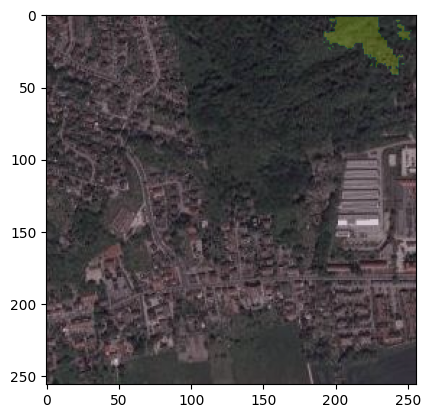

In [ ]:
rand_area = np.array(Image.open(pred_img))

plt.imshow(rand_area)
plt.imshow(pred_mask, alpha=0.2);

#Count the qm of green spaces

In [10]:


# Pfad zu Ihren Bildern
bilder_pfad = '/content/gdrive/MyDrive/Capstone/Data/wuerzburg_data'
#bilder_pfad =  'static_maps_images'

# Liste aller Dateien im Bilderpfad
dateinamen = os.listdir(bilder_pfad)

# DataFrame initialisieren
df = pd.DataFrame(columns=['Bildname', 'Pixelanzahl'])

for dateiname in dateinamen:
    bild_pfad = os.path.join(bilder_pfad, dateiname)

    # Überprüfen, ob der Pfad auf ein Bild zeigt
    if os.path.isfile(bild_pfad) and bild_pfad.endswith('.jpg'):
        # Vorhersage der Maske
        try:
            pred_mask = learn_app.predict(bild_pfad)[0]
            # Zählen der Pixel, die zur Klasse "park" gehören
            pixelanzahl = np.sum(np.array(pred_mask) == 1)
            # Hinzufügen der Daten zum DataFrame
            df = pd.concat([df, pd.DataFrame({'Bildname': [dateiname], 'Pixelanzahl': [pixelanzahl]})], ignore_index=True)
        except Exception as e:
            print(f"Fehler bei der Verarbeitung des Bildes {dateiname}: {e}")

# Gesamtfläche berechnen
gesamtflaeche = df['Pixelanzahl'].sum()
print(f"Gesamtfläche: {gesamtflaeche} Pixel")


Gesamtfläche: 77009 Pixel


In [11]:
print(df)

          Bildname Pixelanzahl
0   32562_5519.jpg         946
1   32568_5515.jpg           4
2   32570_5514.jpg        1026
3   32562_5513.jpg           0
4   32572_5516.jpg           0
5   32565_5520.jpg           0
6   32568_5509.jpg         119
7   32567_5517.jpg        2688
8   32563_5511.jpg           0
9   32563_5516.jpg           0
10  32570_5516.jpg       14995
11  32570_5517.jpg        3937
12  32566_5516.jpg         435
13  32570_5512.jpg        3362
14  32569_5519.jpg         227
15  32564_5515.jpg        3231
16  32568_5511.jpg        5968
17  32568_5517.jpg           0
18  32568_5507.jpg           0
19  32565_5519.jpg           0
20  32567_5511.jpg       10719
21  32568_5518.jpg           0
22  32570_5513.jpg           0
23  32567_5520.jpg           0
24  32570_5515.jpg         317
25  32564_5516.jpg        1208
26  32563_5513.jpg           0
27  32567_5516.jpg        3166
28  32566_5517.jpg           9
29  32569_5517.jpg        3135
30  32572_5515.jpg           0
31  3256

In [12]:
# Pfad zu Ihren Bildern
bilder_pfad = '/content/gdrive/MyDrive/Capstone/Data/munich_data'

# Liste aller Dateien im Bilderpfad
dateinamen = os.listdir(bilder_pfad)

# DataFrame initialisieren
df_munich = pd.DataFrame(columns=['Bildname', 'Pixelanzahl'])

for dateiname in dateinamen:
    bild_pfad = os.path.join(bilder_pfad, dateiname)

    # Überprüfen, ob der Pfad auf ein Bild zeigt
    if os.path.isfile(bild_pfad) and bild_pfad.endswith('.jpg'):
        # Vorhersage der Maske
        try:
            pred_mask = learn_app.predict(bild_pfad)[0]
            # Zählen der Pixel, die zur Klasse "park" gehören
            pixelanzahl = np.sum(np.array(pred_mask) == 1)
            # Hinzufügen der Daten zum DataFrame
            df_munich = pd.concat([df_munich, pd.DataFrame({'Bildname': [dateiname], 'Pixelanzahl': [pixelanzahl]})], ignore_index=True)
        except Exception as e:
            print(f"Fehler bei der Verarbeitung des Bildes {dateiname}: {e}")

# Gesamtfläche berechnen
gesamtflaeche_munich = df_munich['Pixelanzahl'].sum()
print(f"Gesamtfläche: {gesamtflaeche_munich} Pixel")

Gesamtfläche: 1823605 Pixel


In [13]:
print(df_munich)

           Bildname Pixelanzahl
0    32700_5330.jpg           0
1    32701_5331.jpg          38
2    32697_5328.jpg        6531
3    32698_5328.jpg          29
4    32698_5329.jpg          16
..              ...         ...
366  32699_5335.jpg         531
367  32699_5337.jpg           0
368  32699_5339.jpg           0
369  32700_5339.jpg       19924
370  32701_5336.jpg           0

[371 rows x 2 columns]


In [ ]:
# Angenommene Auflösung: 1 Pixel = 1 Quadratmeter
pixel_zu_qm = 1

# Auflösung: 1 Pixel = 0,5 Meter (Seitenlänge eines Pixels)
#pixel_zu_qm = 0.5 * 0.5  # 0,25 Quadratmeter pro Pixel



#München


# Berechnen der Fläche in Quadratmetern für jede Zeile im DataFrame
df_munich['Fläche in qm'] = df_munich['Pixelanzahl'] * pixel_zu_qm


# Berechnen der Gesamtfläche in Quadratmetern
gesamtflaeche_qm_munich = df_munich['Fläche in qm'].sum()
print(f"Gesamtfläche an Parks in München in Quadratmetern: {gesamtflaeche_qm_munich} qm")

#print(df_munich)


#Würzburg


# Berechnen der Fläche in Quadratmetern für jede Zeile im DataFrame
df['Fläche in qm'] = df['Pixelanzahl'] * pixel_zu_qm

# Anzeigen des aktualisierten DataFrame
#print(df)

# Berechnen der Gesamtfläche in Quadratmetern
gesamtflaeche_qm_wuerzburg = df['Fläche in qm'].sum()
print(f"Gesamtfläche an Parks in Würzburg in Quadratmetern: {gesamtflaeche_qm_wuerzburg} qm")


#Calculation of the percentage of green spaces

In our analysis, we used the total number of pixels from all analysed images as the basis for calculating the percentage of green spaces. This approach is based on the assumption that any inaccuracies or deviations in the individual images will even out across the large amount of data. It is important to note that the image selection includes both central and peripheral urban areas, which means that different urban structures, including areas without development, were taken into account.

Instead of making a detailed calculation of the exact urban area of Würzburg and Munich, we decided to use the definitions of the GEO Atlas of Bavaria for the delineations of the cities. As a result, all pixels of all images were included in the analysis, providing a more comprehensive overview of urban and peri-urban green spaces. However, it should be noted that a more precise delineation of urban areas could lead to an adjustment of the calculated percentage, which is a separate and complex problem.

In [ ]:
# Annahme: Jedes Bild hat eine Größe von 250x250 Pixeln
pixel_pro_bild = 256 * 256

# Anzahl der Bilder für Würzburg und München
anzahl_bilder_wuerzburg = len(df)
anzahl_bilder_muenchen = len(df_munich)

# Gesamtzahl der Pixel in allen Bildern für Würzburg und München
gesamt_pixel_wuerzburg = anzahl_bilder_wuerzburg * pixel_pro_bild
gesamt_pixel_muenchen = anzahl_bilder_muenchen * pixel_pro_bild



# Berechnung des Prozentsatzes der Park-Pixel für Würzburg
prozent_parks_wuerzburg = (df['Pixelanzahl'].sum() / gesamt_pixel_wuerzburg) * 100

# Berechnung des Prozentsatzes der Park-Pixel für München
prozent_parks_muenchen = (df_munich['Pixelanzahl'].sum() / gesamt_pixel_muenchen) * 100

# Ausgabe der Ergebnisse
print(f"Prozentsatz der Parks in Würzburg: {prozent_parks_wuerzburg:.2f}%")
print(f"Prozentsatz der Parks in München: {prozent_parks_muenchen:.2f}%")


#Gradio installieren

In [ ]:
%pip install -q typing-extensions==4.5.0 kaleido accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers

In [ ]:
import gradio as gr
import requests #für static maps API
!pip install pillow

import math
from IPython.display import display
import matplotlib.pyplot as plt

## Gradio Interface 1: Input Image -> Output Image + Mask

In [ ]:
def predict_image(image):
    try:
        # Konvertierung der Eingabe in PIL-Bild, falls notwendig
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image.astype('uint8'), 'RGB')

        # Speichern des Bildes in einem temporären Pfad
        temp_path = "/tmp/temp_image.jpg"
        image.save(temp_path)

        # Vorhersage der Maske durch Ihr Modell
        pred_mask = learn_app.predict(temp_path)[0]

        # Zählen der Parkflächenpixel
        park_pixel = np.sum(np.array(pred_mask) == 1)  # Angenommen, Park wird durch 1 dargestellt
        park_flaeche_qm = park_pixel  # Angenommen, 1 Pixel entspricht 1 Quadratmeter

        # Erstellen eines kombinierten Bildes mit Matplotlib
        plt.figure()
        plt.imshow(np.array(image))
        plt.imshow(pred_mask, alpha=0.5)
        plt.axis('off')

        # Speichern des kombinierten Bildes in einem BytesIO-Objekt
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close()
        buf.seek(0)
        combined_image = Image.open(buf)

        # Textausgabe vorbereiten
        text_output = f"Das Bild enthält {park_pixel} Pixel an Grünflächen, was bei der Annahme von einem Pixel entspricht einem Quadratmeter  {park_flaeche_qm} qm Grünfläche entspricht."

        return combined_image, text_output
    except Exception as e:
        print(f"Ein Fehler ist aufgetreten: {e}")
        raise

# Erstellen des Gradio-Interface mit Bild- und Textausgabe
interface = gr.Interface(fn=predict_image, inputs="image", outputs=["image", "text"])

# Starten des Interface
interface.launch()


##Funktionen für Gradio Interface 2: Google Static Maps API Pipeline

*   Grid erstellen
*   Bilder herunterladen
*   PNG zu JPG transformieren
*   Auf Bilder Modell anwenden und Ergebnisse in Data Frame speichern
*   Prüfen ob Bilder heruntergeladen
*   Bilder löschen
*   Berechnen der Summe aller Parkflächen und kombinieren der Maske und des Bildes mit dem höchsten Anteil an Parkflächen











In [16]:
API_KEY = "" #Hier eigenen API Schlüssel eingeben wenn die Funktion manuell ausgeführt werden soll, ansonsten einfach über Gradio Interface 2
output_folder = "static_maps_images"

#Daten für die Testfunktion

#Koordinaten für Würzburg
left_bottom = (49.784875098932524,9.921752199412644)
right_top = (49.803039,9.953005)
grid_size = 0.01            # Größe der Rasterfelder in Grad
zoom = 15                   # Zoom-Level für die Karten
api_key = API_KEY

In [17]:

def create_grid(left_bottom, right_top, grid_size):
    grid = []

    min_lon, min_lat = left_bottom
    max_lon, max_lat = right_top

    current_lon = min_lon
    current_lat = min_lat

    while current_lat <= max_lat:
        while current_lon <= max_lon:
            grid.append((current_lon, current_lat))
            current_lon += grid_size

        current_lon = min_lon
        current_lat += grid_size

    return grid

def calculate_bounding_box(latitude, longitude, grid_size):
    half_grid_size = grid_size / 2.0
    left_lon = longitude - half_grid_size
    bottom_lat = latitude - half_grid_size
    right_lon = longitude + half_grid_size
    top_lat = latitude + half_grid_size
    return left_lon, bottom_lat, right_lon, top_lat

def download_static_maps_images(coordinates, zoom=15, image_size=(640, 640), api_key=None, output_folder=output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for coord in coordinates:
        lat, lon = coord
        bbox = calculate_bounding_box(lat, lon, 0.1)

        center_lat = (bbox[1] + bbox[3]) / 2
        center_lon = (bbox[0] + bbox[2]) / 2

        png_image_filename = f"{output_folder}/image_{lat}_{lon}.png"

        if not os.path.exists(png_image_filename):
            url = "https://maps.googleapis.com/maps/api/staticmap"
            params = {
                "center": f"{center_lat},{center_lon}",
                "zoom": zoom,
                "size": f"{image_size[0]}x{image_size[1]}",
                "key": api_key,
                "maptype": "satellite",
                "format": "png"
            }

            response = requests.get(url, params=params)
            if response.status_code == 200:
                with open(png_image_filename, "wb") as f:
                    f.write(response.content)
                print(f"Bild für Koordinate {lat}, {lon} heruntergeladen.")
            else:
                print(f"Fehler beim Herunterladen für Koordinate {lat}, {lon}. Statuscode: {response.status_code}")

def convert_png_to_jpg(output_folder=output_folder):
    dateien = os.listdir(output_folder)
    for datei in dateien:
        if datei.endswith('.png'):
            png_image_filename = os.path.join(output_folder, datei)
            jpg_image_filename = png_image_filename.replace('.png', '.jpg')

            with Image.open(png_image_filename) as img:
                img.convert('RGB').save(jpg_image_filename, "JPEG")
            print(f"{png_image_filename} nach {jpg_image_filename} konvertiert.")

    print("Konvertierung abgeschlossen.")

def predict_images_and_get_stats_with_mask_data(images_folder, learn_app):
    dateinamen = os.listdir(images_folder)
    df = pd.DataFrame(columns=['Bildname', 'Pixelanzahl', 'Mask-Daten'])

    max_green_pixel_image = None
    max_green_pixel_count = 0

    for dateiname in dateinamen:
        bild_pfad = os.path.join(images_folder, dateiname)

        if os.path.isfile(bild_pfad) and bild_pfad.endswith('.jpg'):
            try:
                pred_mask = learn_app.predict(bild_pfad)[0]
                pixelanzahl = np.sum(np.array(pred_mask) == 1)

                # Hinzufügen der Vorhersagemaske und Pixelanzahl zum DataFrame
                df = pd.concat([df, pd.DataFrame({'Bildname': [dateiname], 'Pixelanzahl': [pixelanzahl], 'Mask-Daten': [pred_mask.numpy()]})], ignore_index=True)

                if pixelanzahl > max_green_pixel_count:
                    max_green_pixel_count = pixelanzahl
                    max_green_pixel_image = Image.open(bild_pfad)

            except Exception as e:
                print(f"Fehler bei der Verarbeitung des Bildes {dateiname}: {e}")

    # Berechnen der Gesamtanzahl der Pixel
    gesamt_pixelanzahl = df['Pixelanzahl'].sum()

    return max_green_pixel_image, gesamt_pixelanzahl, df


# Funktion, um zu überprüfen, ob alle Bilder heruntergeladen wurden
def sind_alle_bilder_heruntergeladen(output_folder):
    for coord in grid_subset:
        lat, lon = coord
        jpg_image_filename = f"{output_folder}/image_{lat}_{lon}.jpg"
        if not os.path.exists(jpg_image_filename):
            return False
    return True


def alle_bilder_löschen(output_folder):

    # Überprüfen, ob der Ordner existiert
    if not os.path.exists(output_folder):
        print(f"Der Ordner {output_folder} existiert nicht.")
    else:
        # Liste aller Dateien im Ordner
        dateien = os.listdir(output_folder)
        jpg_dateien = [datei for datei in dateien if datei.endswith('.jpg')]

        # Ausgeben der Anzahl der .jpg Dateien
        print(f"Anzahl der .jpg Dateien: {len(jpg_dateien)}")

        # Überprüfen und Anzeigen einiger Bilder
        for dateiname in jpg_dateien[:5]:  # Anzeigen der ersten 5 Bilder
            bild_pfad = os.path.join(output_folder, dateiname)
            with Image.open(bild_pfad) as bild:
                print(f"{dateiname}: Format - {bild.format}")
                display(bild)
    return True


def find_image_with_max_pixels_and_apply_mask(df, images_folder):
    # Finden des Bildes mit der höchsten Pixelanzahl
    df['Pixelanzahl'] = pd.to_numeric(df['Pixelanzahl'], errors='coerce')

    max_pixel_row = df.loc[df['Pixelanzahl'].idxmax()]
    bildname = max_pixel_row['Bildname']
    mask_data = max_pixel_row['Mask-Daten']
    bild_pfad = os.path.join(images_folder, bildname)

    # Laden des Bildes
    image = Image.open(bild_pfad)

    # Anwendung der Maske auf das Bild
    plt.figure()
    plt.imshow(np.array(image))
    plt.imshow(mask_data, alpha=0.5)  # Überlagern der Maske
    plt.axis('off')

    # Speichern des kombinierten Bildes in einem BytesIO-Objekt
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close()
    buf.seek(0)
    combined_image = Image.open(buf)

    # Berechnen der Gesamtanzahl der Pixel über alle Bilder
    gesamt_pixelanzahl = df['Pixelanzahl'].sum()

    text_output = f"Gesamtanzahl der Parkflächenpixel über alle Bilder: {gesamt_pixelanzahl}"

    return combined_image, text_output






In [ ]:
predict_images_and_get_stats_with_spatial_data(output_folder, learn_app)
print(df)

## Manuelles Testen der Pipeline

In [ ]:
# Beispielaufruf:
#left_bottom = (52.375, 13)  # Längengrad/Breitengrad der linken unteren Ecke
#right_top = (52.68, 13.8)   # Längengrad/Breitengrad der rechten oberen Ecke

grid = create_grid(left_bottom, right_top, grid_size)
grid_subset = grid[:10]


print("Generierte Koordinaten:", grid_subset)
alle_bilder_löschen(output_folder)
download_static_maps_images(grid_subset, zoom, api_key=API_KEY, output_folder=output_folder)
convert_png_to_jpg(output_folder=output_folder)
sind_alle_bilder_heruntergeladen(output_folder)


In [ ]:
max_green_pixel_image, gesamt_pixelanzahl, df = predict_images_and_get_stats_with_mask_data("static_maps_images", learn_app)


In [ ]:
print(df['Pixelanzahl'].dtype)
df['Pixelanzahl'] = pd.to_numeric(df['Pixelanzahl'], errors='coerce')
print(df['Pixelanzahl'].dtype)

In [21]:
combined_image, text_output = find_image_with_max_pixels_and_apply_mask(df, "static_maps_images")

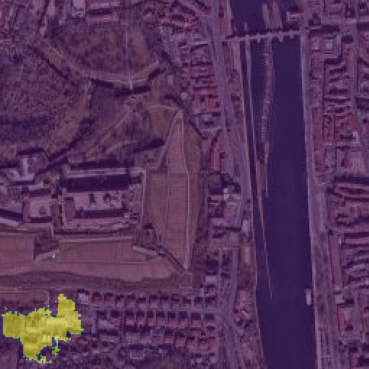

2100


In [23]:
# Visualisieren der Ergebnisse
display(combined_image)
print(gesamt_pixelanzahl)


##Gradio Inteface 2: Interface starten

In [ ]:
def gradio_pipeline(left_bottom_str, right_top_str, api_key):
    # Umwandlung der Koordinatenstrings in Tupel
    left_bottom = tuple(map(float, left_bottom_str.split(',')))
    right_top = tuple(map(float, right_top_str.split(',')))

    # Festlegen der Standardwerte für grid_size und zoom
    default_grid_size = 0.01
    default_zoom = 15

    grid = create_grid(left_bottom, right_top, default_grid_size)
    grid_subset = grid[:30]  # Erhöhung der Anzahl der Punkte falls gewünscht

    #löschen aller Bilder im Output_folder
    alle_bilder_löschen(output_folder)
    # Herunterladen und Konvertieren der Bilder
    download_static_maps_images(grid_subset, default_zoom, api_key=api_key, output_folder=output_folder)
    convert_png_to_jpg(output_folder=output_folder)

    # Vorhersagen durchführen und Statistiken erhalten
    max_green_pixel_image, gesamt_pixelanzahl, df = predict_images_and_get_stats_with_mask_data(output_folder, learn_app)

    # Anwenden der Maske auf das Bild mit den meisten grünen Pixeln und Textausgabe generieren
    combined_image, text_output = find_image_with_max_pixels_and_apply_mask(df, output_folder)

    return combined_image, text_output

# Gradio Interface Konfiguration
default_left_bottom = "49.784875098932524,9.921752199412644"
default_right_top = "49.803039,9.953005"

iface = gr.Interface(
    fn=gradio_pipeline,
    inputs=[
        gr.Textbox(value=default_left_bottom, label="Linke untere Ecke (Format: lat,lon)"),
        gr.Textbox(value=default_right_top, label="Rechte obere Ecke (Format: lat,lon)"),
        gr.Textbox(label="Google Maps API-Schlüssel", placeholder="Ihr API-Schlüssel hier")
    ],
    outputs=[
        gr.Image(label="Bild mit der höchsten Anzahl an Parkflächenpixeln"),
        gr.Textbox(label="Gesamtanzahl der Parkflächenpixel")
    ]
)


In [ ]:
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b7a45cece7a3c31cfb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import os
from PIL import Image
from IPython.display import display

bilder_ordner = "static_maps_images"  # Pfad zum Ordner mit den Bildern

# Überprüfen, ob der Ordner existiert
if not os.path.exists(bilder_ordner):
    print(f"Der Ordner {bilder_ordner} existiert nicht.")
else:
    # Liste aller Dateien im Ordner
    dateien = os.listdir(bilder_ordner)
    jpg_dateien = [datei for datei in dateien if datei.endswith('.jpg')]

    # Ausgeben der Anzahl der .jpg Dateien
    print(f"Anzahl der .jpg Dateien: {len(jpg_dateien)}")

    # Überprüfen und Anzeigen einiger Bilder
    for dateiname in jpg_dateien[:5]:  # Anzeigen der ersten 5 Bilder
        bild_pfad = os.path.join(bilder_ordner, dateiname)
        with Image.open(bild_pfad) as bild:
            print(f"{dateiname}: Format - {bild.format}")
            display(bild)
